In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train

In [2]:
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import JupyterNotebookReporter

In [3]:
torch.manual_seed(100)
num_workers=32

max_num_epochs=100
num_epochs=100
num_samples=10
betas=[0.95, 0.98]
data_dir = '/home/studenti/ballerini/Multimodal_RSA/src/util/au-emo_2.csv'
checkpoint_dir='./tuning'
expert = 'poe'

modes={'au':True, 'face':None, 'emotion':True}

config = {
    'batch_size':tune.choice([64, 128, 256, 512]),
    'z_dim':tune.choice([25, 32, 50, 64]),
    'hidden_dim':tune.choice([128, 256, 512, 1024]),
    'lr': tune.loguniform(1e-5, 1e-2),
    'alpha': tune.choice([1, 5e-1]),
    'beta': tune.loguniform(1e-7, 1e-2),
    'au_weight':tune.loguniform(1e-3, 1e5),
    'emotion_weight':tune.loguniform(1e-6, 1e2),
}

In [4]:
def hyper_train(config, data_dir, num_epochs, use_cuda=True, checkpoint_dir=None):
    model: torch.nn.Module = build_model(
        cat_dim=8,      
        au_dim=17,     
        latent_space_dim=config['z_dim'],     
        hidden_dim=config['hidden_dim'],               
        num_filters=None,                 
        modes=modes,              
        au_weight=config['au_weight'],           
        emotion_weight=config['emotion_weight'],              
        expert_type=expert,                  
        use_cuda=True).double()
        
    optimizer = torch.optim.Adam(
        params=model.parameters(), 
        lr=config['lr'], 
        betas=betas)
    
    trainset_loader, valset_loader, _ = U.load_data(data_dir=data_dir, batch_size=config['batch_size'])
    '''    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    '''
    
    beta = config['beta']
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        
        for data in trainset_loader:
            # get the inputs; data is a list of [inputs, labels]
            au, emotions = data
            
            if use_cuda:
                if au is not None:
                    au = au.cuda()
                if emotions is not None:
                    emotions = emotions.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()
            
        #-------------------------------------------------
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=au,
                emotions=emotions
            )

            loss = model.loss_function(
                au=au,
                emotions=emotions,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
        
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=None,
                emotions=emotions
            )

            loss = model.loss_function(
                au=None,
                emotions=emotions,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
        #-------------------------------------------------
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=au,
                emotions=None
            )

            loss = model.loss_function(
                au=au,
                emotions=None,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
            
        y_true = []
        y_pred = []
        val_loss = 0
        val_steps = 0
        for data in valset_loader:
            with torch.no_grad():
                au, emotions = data
            
                if use_cuda:
                    if au is not None:
                        au = au.cuda()
                    if emotions is not None:
                        emotions = emotions.cuda()

                (
                    au_reconstruction,
                    emotion_reconstruction,
                    z_loc_expert,
                    z_scale_expert,
                    latent_sample
                ) = model(
                    au=None,
                    emotions=emotions
                )
                
                loss = model.loss_function(
                    au=au,
                    emotions=emotions,
                    au_reconstruction=au_reconstruction,
                    emotions_reconstruction=emotion_reconstruction,
                    z_loc=z_loc_expert,
                    z_scale=z_scale_expert,
                    beta=beta,
                    latent_sample=latent_sample
                )
                
                reconstructed_emotions = torch.argmax(emotion_reconstruction, 1)
                y_true += emotions.cpu()
                y_pred += reconstructed_emotions.cpu()
                val_loss += loss['total_loss'].cpu().numpy()
                val_steps += 1
                
        accuracy = accuracy_score(y_true, y_pred)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        
        
        tune.report(loss=(val_loss / val_steps), accuracy=accuracy)
    print("Finished Training")
    

In [5]:
scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=max_num_epochs,
    grace_period=10,
    reduction_factor=3)    

reporter = JupyterNotebookReporter(
    True,
    metric_columns=["accuracy","training_iteration"])

result = tune.run(
        partial(hyper_train, 
                data_dir=data_dir, 
                num_epochs=num_epochs, 
                checkpoint_dir=checkpoint_dir),
        resources_per_trial={"cpu": 8, "gpu": 0.1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

best_trial = result.get_best_trial("accuracy", "max", "last")

print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

Trial name,status,loc,alpha,au_weight,batch_size,beta,emotion_weight,hidden_dim,lr,z_dim,accuracy,training_iteration
hyper_train_cc667_00000,TERMINATED,159.149.133.23:3896403,1,281.551,512,0.00293183,1.68212e-06,256,1.36005e-05,50,0.99306,100
hyper_train_cc667_00001,TERMINATED,159.149.133.23:3896433,1,635.575,512,0.000310232,7.05534e-06,1024,9.88886e-05,32,1,100
hyper_train_cc667_00002,TERMINATED,159.149.133.23:3896436,0.5,46988.1,256,0.000358651,0.0351834,128,0.000351303,32,1,100
hyper_train_cc667_00003,TERMINATED,159.149.133.23:3896439,1,4122.67,256,5.02722e-05,0.00499154,256,0.00230602,32,1,100
hyper_train_cc667_00004,TERMINATED,159.149.133.23:3896441,1,0.0726364,64,8.42419e-05,0.00322064,256,0.000303919,25,0.998738,10
hyper_train_cc667_00005,TERMINATED,159.149.133.23:3896442,0.5,9416.57,512,0.000392929,0.00021123,1024,0.000344711,32,1,100
hyper_train_cc667_00006,TERMINATED,159.149.133.23:102511,0.5,0.00151694,64,0.00215588,1.7604,1024,3.53966e-05,25,1,100
hyper_train_cc667_00007,TERMINATED,159.149.133.23:1275813,1,53035.2,128,4.84267e-07,0.00524981,1024,0.000253442,64,1,100
hyper_train_cc667_00008,TERMINATED,159.149.133.23:1378189,0.5,2.93056,512,1.85361e-07,0.282465,256,0.00152786,32,1,100
hyper_train_cc667_00009,TERMINATED,159.149.133.23:1447279,1,0.00271906,256,1.09188e-07,5.75495e-06,1024,0.000268727,25,0.135016,10


2022-07-11 16:14:55,947	INFO tune.py:747 -- Total run time: 1306.15 seconds (1305.95 seconds for the tuning loop).


Best trial config: {'batch_size': 512, 'z_dim': 32, 'hidden_dim': 1024, 'lr': 9.88885589031385e-05, 'alpha': 1, 'beta': 0.00031023194033706977, 'au_weight': 635.57475767786, 'emotion_weight': 7.055343091615661e-06}
Best trial final validation loss: 16.359323632511792
Best trial final validation accuracy: 1.0


In [6]:
model_args = {
    'cat_dim':8,      
    'au_dim':17,     
    'latent_space_dim':best_trial.config['z_dim'],     
    'hidden_dim':best_trial.config['hidden_dim'],               
    'num_filters':None,                 
    'modes':modes,
    
    'au_weight':best_trial.config['au_weight'],           
    'emotion_weight':best_trial.config['emotion_weight'],              
    'expert_type':expert,                  
    'use_cuda':True}


train_args = {
    'learning_rate' : best_trial.config['lr'],
    'alpha':best_trial.config['alpha'],
    'beta': best_trial.config['beta'],
    'optim_betas' : betas,
    'num_epochs' : num_epochs,
    'batch_size' : best_trial.config['batch_size']
}

print('model_args=', model_args)
print('train_args=', train_args)

model_args= {'cat_dim': 8, 'au_dim': 17, 'latent_space_dim': 32, 'hidden_dim': 1024, 'num_filters': None, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 635.57475767786, 'emotion_weight': 7.055343091615661e-06, 'expert_type': 'poe', 'use_cuda': True}
train_args= {'learning_rate': 9.88885589031385e-05, 'alpha': 1, 'beta': 0.00031023194033706977, 'optim_betas': [0.95, 0.98], 'num_epochs': 100, 'batch_size': 512}


In [7]:
best_trained_model =  build_model(**model_args).double()

In [8]:
best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))

best_trained_model.load_state_dict(model_state)

<All keys matched successfully>

In [9]:
save_model = True

if save_model:
    PATH = "../trained_models/best-train-"+expert+".save"
    torch.save({'model_args' : model_args,
                'train_args' : train_args,
                'model_state' : model_state
                }, PATH)

              precision    recall  f1-score   support

     neutral       0.60      0.23      0.33       135
        calm       0.74      0.35      0.47       259
       happy       0.78      0.72      0.74       253
         sad       0.52      0.50      0.51       270
       angry       0.28      0.86      0.42       287
     fearful       0.69      0.10      0.18       235
     disgust       0.81      0.53      0.64       257
   surprised       0.36      0.28      0.31       285

    accuracy                           0.47      1981
   macro avg       0.60      0.45      0.45      1981
weighted avg       0.59      0.47      0.46      1981



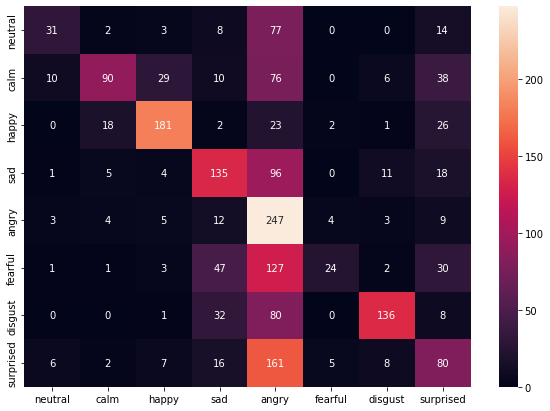

In [10]:
_, _, testset_loader = U.load_data(data_dir=data_dir, batch_size=best_trial.config['batch_size'])

labels = list(Rd.emocat.values())
y_true, y_pred = U.au_classiffication_accuracy(best_trained_model, testset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|████████████████████████████████████████████████████████████████| 2048/2048 [00:04<00:00, 413.77it/s]


              precision    recall  f1-score   support

     neutral       1.00      0.08      0.14      3917
        calm       1.00      1.00      1.00      4090
       happy       1.00      1.00      1.00      4088
         sad       0.52      0.96      0.67      4181
       angry       0.43      1.00      0.60      4085
     fearful       0.64      1.00      0.78      4156
     disgust       1.00      0.12      0.21      4179
   surprised       0.16      0.00      0.00      4072

    accuracy                           0.65     32768
   macro avg       0.72      0.64      0.55     32768
weighted avg       0.72      0.65      0.55     32768



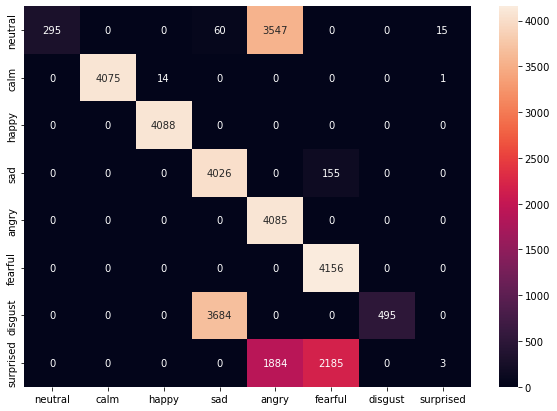

In [11]:
labels = list(Rd.emocat.values())
y_true, y_pred = U.au_recon_and_classiffication_accuracy(best_trained_model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

In [12]:
model_args =  {'cat_dim': 8, 'au_dim': 17, 'latent_space_dim': 25, 'hidden_dim': 512, 'num_filters': None, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 262330.5833373258, 'emotion_weight': 1.0523573323659556, 'expert_type': 'poe', 'use_cuda': True}
train_args =  {'learning_rate': 0.001, 'alpha': 0.5, 'beta': 1e-05, 'optim_betas': [0.95, 0.98], 'num_epochs': 50, 'batch_size': 128}